# Projeto 3: Segmentação de clientes no ecommerce


Realizar uma segmentação de clientes aplicando a metodologia RFM para um e-commerce.

# 1 - Contexto
 
O dataset utilizado neste notebook pode ser obtido [nesse projeto no Kaggle](https://www.kaggle.com/datasets/datacertlaboratoria/projeto-3-segmentao-de-clientes-no-ecommerce).





Neste projeto, deverá ser realizada uma análise descritiva para o CEO de uma empresa de varejo que apresentará o quão bem ou mal as vendas estão indo na empresa, medir o engajamento do cliente com base em uma análise de coorte (Notebook 02 - Análise de coorte de clientes) e realizar uma segmentação de clientes aplicando a metodologia RFM (Notebook 03 - Segmentação de clientes usando RFM), para que o negócio possa focar seus esforços e adotar estratégias diferenciadas para cada segmento. 

No entanto, antes de tudo este projeto tem como objetivo mostrar a importância da limpeza e do tratamento dos dados antes de realizar qualquer análise.

Como resultado final neste notebook será gerado um arquivo CSV para apoio nas análises em ferramentas de visualização.

# 2 - Importar, entender o dataset e limpar os dados

## Importando as bibliotecas e o dataset

As bibliotecas utilizadas neste projeto são: [Pandas](https://pandas.pydata.org/pandas-docs/stable/index.html), [NumPy](https://numpy.org/), [Seaborn](https://seaborn.pydata.org/index.html) e [Matplolib](https://matplotlib.org/).

In [32]:
%pip install --upgrade xlrd

Note: you may need to restart the kernel to use updated packages.


In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [34]:
# Verificando as versões das bibliotecas utilizadas
print('Versão do Pandas -> %s' % pd.__version__)
print('Versão do Numpy -> %s' % np.__version__)
print('Versão do Seaborn -> %s' % sns.__version__)

Versão do Pandas -> 1.3.4
Versão do Numpy -> 1.20.3
Versão do Seaborn -> 0.11.2


In [35]:
# importando o dataset que está no formato csv
df = pd.read_csv("./dados/vendas-por-fatura.csv")

## Entendendo o dataset importado

In [36]:
df.head()

,N° da fatura,Data da fatura,ID Cliente,País,Quantidade,Valor
0,548370,3/30/2021 16:14:00,15528.0,United Kingdom,123,"229,33"
1,575767,11/11/2021 11:11:00,17348.0,United Kingdom,163,"209,73"
2,C570727,10/12/2021 11:32:00,12471.0,Germany,-1,"-1,45"
3,549106,4/6/2021 12:08:00,17045.0,United Kingdom,1,"39,95"
4,573112,10/27/2021 15:33:00,16416.0,United Kingdom,357,"344,83"


In [37]:
df.columns

Index(['N° da fatura', 'Data da fatura', 'ID Cliente', 'País', 'Quantidade',
       'Valor'],
      dtype='object')

O dataset possui as 6 colunas: 'N° da fatura', 'Data da fatura', 'ID Cliente', 'País', 'Quantidade' e 'Valor' referente as faturas criadas sobre as vendas para os clientes.

Iremos renomear as colunas para facilitar a sua manipulação.

In [38]:
# Renomeando as colunas
df.columns = df.columns.str.replace(" ", "_")
df.columns

Index(['N°_da_fatura', 'Data_da_fatura', 'ID_Cliente', 'País', 'Quantidade',
       'Valor'],
      dtype='object')

Agora iremos analisar os tipos de dados:

In [39]:
# analisando os tipos de dados 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25953 entries, 0 to 25952
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   N°_da_fatura    25953 non-null  object 
 1   Data_da_fatura  25953 non-null  object 
 2   ID_Cliente      22229 non-null  float64
 3   País            25953 non-null  object 
 4   Quantidade      25953 non-null  int64  
 5   Valor           25953 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


## 2.1 - Detecção de nulos ou vazios

É possível analisar que existem apenas 22229 linhas com dados sobre 'ID Cliente' enquanto há 25953 linhas preenchidas referente as outras colunas. Ou seja, temos que existem 3.724 registros que não conseguimos identificar quem é o cliente. 

Como desejamos realizar a análise de coorte, é muito importante termos certeza que **NÃO** estaremos contabilizando clientes repetidos. Por isso, iremos remover esses registros com 'ID Cliente' nulos.

In [40]:
# Removendo linhas com registro nulo na coluna 'ID_Cliente'
df = df.dropna(subset=["ID_Cliente"])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22229 entries, 0 to 25951
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   N°_da_fatura    22229 non-null  object 
 1   Data_da_fatura  22229 non-null  object 
 2   ID_Cliente      22229 non-null  float64
 3   País            22229 non-null  object 
 4   Quantidade      22229 non-null  int64  
 5   Valor           22229 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [41]:
# verificando se existem valores nulos em qualquer uma das colunas
df.isnull().values.any()

False

Também é possível validar que não há campos nulos em nenhuma das colunas existentes.

## 2.2 Detecção e remoção de dados duplicados

In [42]:
# Removendo os dados duplicados do dataset
df.drop_duplicates(inplace=True)

df.shape

(22221, 6)

Foram identificadas e removidas 8 linhas duplicadas. Após isso temos 22221 registros únicos no nosso dataset.

## 2.3 Detecção e eliminação de quantidades negativas

Como as faturas que iniciam com a letra 'C' correspondem a devolução e desejamos analisar as vendas do negócio, então iremos identificar e remover esses valores do nosso dataset.

In [43]:
devolucao = df['N°_da_fatura'].str.startswith('C')
df[devolucao].head()


,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor
2,C570727,10/12/2021 11:32:00,12471.0,Germany,-1,"-1,45"
10,C543628,2/10/2021 15:51:00,16558.0,United Kingdom,-5,"-9,25"
17,C553508,5/17/2021 13:44:00,14000.0,United Kingdom,-3,"-1,95"
20,C577693,11/21/2021 11:48:00,12628.0,Germany,-3,"-16,85"
22,C547309,3/22/2021 11:17:00,17416.0,United Kingdom,-12,"-45,00"


In [44]:
df[devolucao].shape

(3655, 6)

Foram identificadas 3655 compras que tiveram devolução, sendo assim elas serão removidas do dataset.

In [45]:
df.drop(df[devolucao].index, inplace=True)


In [46]:
df.shape

(18566, 6)

Como resultado temos 18566 registros após aplicar a limpeza nos dados.

## Tratando os dados

Agora iremos realizar os tratamentos necessários para realizar as avaliações e cálculos necessários.

In [47]:
# Convertendo para tipo inteiro o 'ID_Cliente'
df['ID_Cliente'] = df['ID_Cliente'].astype(int)

In [48]:
# Convertendo tipo da 'Data da Fatura' para data
df["Data_da_fatura"] = pd.to_datetime(df["Data_da_fatura"])

In [49]:
# alterando a separação dos valores de ',' para '.' na coluna Valor
df['Valor'] = df['Valor'].str.replace(",", ".")

In [50]:
# alterando o tipo da coluna 'Valor' para float
df['Valor'] = pd.to_numeric(df['Valor'])

In [51]:
# Obtendo Ano e Mês
df['Ano_mes'] = df['Data_da_fatura'].dt.to_period('M')

In [52]:
# Ordenando pela Data da Fatura de maneira ascendente para facilitar nossas análises
df.sort_values(by=['Data_da_fatura'], inplace=True)

In [53]:
df.head(7)

,N°_da_fatura,Data_da_fatura,ID_Cliente,País,Quantidade,Valor,Ano_mes
9367,536365,2020-12-01 08:26:00,17850,United Kingdom,40,139.12,2020-12
18259,536366,2020-12-01 08:28:00,17850,United Kingdom,12,22.20,2020-12
11185,536368,2020-12-01 08:34:00,13047,United Kingdom,15,70.05,2020-12
6876,536367,2020-12-01 08:34:00,13047,United Kingdom,83,278.73,2020-12
8195,536369,2020-12-01 08:35:00,13047,United Kingdom,3,17.85,2020-12
505,536370,2020-12-01 08:45:00,12583,France,449,855.86,2020-12
12932,536371,2020-12-01 09:00:00,13748,United Kingdom,80,204.00,2020-12


In [54]:
df.dtypes 

N°_da_fatura              object
Data_da_fatura    datetime64[ns]
ID_Cliente                 int32
País                      object
Quantidade                 int64
Valor                    float64
Ano_mes                period[M]
dtype: object

# 3 - Análise das métricas de vendas

## 3.1 Análise do número de faturas por país

Agora iremos analisar a quantidade total de faturas emitidas por país e a porcentagem de faturas representada por país.

In [55]:
# Quantidade de Fatura por país
df_fatura_pais = pd.DataFrame(df.groupby(['País'])['N°_da_fatura'].count()).reset_index()
df_fatura_pais.columns = ['País', 'N°_de_faturas']
df_fatura_pais.sort_values('N°_de_faturas', ascending=False, inplace=True)
df_fatura_pais.head(6)

,País,N°_de_faturas
35,United Kingdom,16676
14,Germany,457
13,France,390
10,EIRE,261
3,Belgium,98
23,Netherlands,95


In [56]:
#calculando percentual de faturas por país
df_fatura_pais['Percentual_de_faturas_%'] = (df_fatura_pais['N°_de_faturas']/df_fatura_pais['N°_de_faturas'].sum()) * 100
df_fatura_pais['Percentual_de_faturas_%'] = df_fatura_pais['Percentual_de_faturas_%'].round(2)
df_fatura_pais.head(6)

,País,N°_de_faturas,Percentual_de_faturas_%
35,United Kingdom,16676,89.82
14,Germany,457,2.46
13,France,390,2.10
10,EIRE,261,1.41
3,Belgium,98,0.53
23,Netherlands,95,0.51


O *Reino Unido* é o campeão em compras na UK Merch e como a empresa nasceu lá, é bem provável que isso explique o por quê dele estar em primeiro lugar. 

Os próximos 5 países com maior quantidade de compras são Alemanha, França, Irlanda, Bélgica e Holanda, respectivamente.

## 3.2 Análise de valor total por país

Agora iremos incluir o valor médio, o valor mínimo e o valor máximo por país.

In [57]:
# calculando o valor médio, máximo e mínimo das faturas por país
df_valor_medio = pd.DataFrame(df.groupby(['País'])['Valor'].mean()).round(2).reset_index()
df_valor_max = pd.DataFrame(df.groupby(['País'])['Valor'].max()).reset_index()
df_valor_min = pd.DataFrame(df.groupby(['País'])['Valor'].min()).reset_index()

# criando dataframe com a união dos valores médio, máximo e mínimo encontrados
df_valor_pais = pd.merge(df_valor_medio, df_valor_min, on="País")
df_valor_pais = pd.merge(df_valor_pais, df_valor_max, on="País")
df_valor_pais.rename(columns={"Valor_x":"Valor_médio", "Valor_y":"Valor_mínimo", "Valor":"Valor_máximo"}, inplace=True)

In [58]:
# criando dataframe com junção dos dados de quantidade e percentual de faturas e valores médio, máximo e mínimo por país
df_analise_pais = pd.merge(df_fatura_pais, df_valor_pais, on="País")

# ordenando pelo valor médio de modo decrescente
df_analise_pais.sort_values('Valor_médio', ascending=False, inplace=True)
df_analise_pais.head(5)

,País,N°_de_faturas,Percentual_de_faturas_%,Valor_médio,Valor_mínimo,Valor_máximo
22,Singapore,7,0.04,3039.90,999.26,6068.06
5,Netherlands,95,0.51,3004.70,0.00,20277.92
7,Australia,57,0.31,2430.20,61.20,22775.93
15,Japan,20,0.11,1870.82,15.30,5735.24
33,Lebanon,1,0.01,1693.88,1693.88,1693.88


In [59]:
# ordendando pelo percentual de modo decrescente
df_analise_pais.sort_values('Percentual_de_faturas_%', ascending=False, inplace=True)
df_analise_pais.head(5)

,País,N°_de_faturas,Percentual_de_faturas_%,Valor_médio,Valor_mínimo,Valor_máximo
0,United Kingdom,16676,89.82,438.26,0.00,168469.60
1,Germany,457,2.46,500.80,3.00,9341.26
2,France,390,2.10,535.96,4.63,8895.76
3,EIRE,261,1.41,1017.42,1.45,16774.72
4,Belgium,98,0.53,420.37,34.00,1491.59


O Reino Unido possui um **valor médio de £438,26** por fatura. Esse valor pode ser considerado baixo quando analisamos os 5 maiores valores médios. 

Também percebemos que em alguns países como a Holanda e o Reino Unido apresentam valores mínimos de fatura de £0,00. A partir disso, seria importante identificar se é um erro de lançamento de dados ou se são doações que foram realizadas. 

## 3.3 Faturas geradas por mês

Vamos visualizar qual a quantidade de faturas geradas por mês ao longo do período.

In [60]:
# agrupando a quantidade de fatura por Mês e Ano.
df_fatura_mes = pd.DataFrame(df.groupby(['Ano_mes'])['N°_da_fatura'].count()).reset_index()
df_fatura_mes.rename(columns={"N°_da_fatura": "Quantidade_de_faturas"}, inplace=True)

# convertendo tipo do dado da coluna "Ano_mes" para string para ser utilizando no gráfico que será gerado
df_fatura_mes['Ano_mes'] = df_fatura_mes['Ano_mes'].astype(str)

Para facilitar a nossa visualização, vamos apresentar esses dados em um gráfico de linha. 

Text(0.5, 1.0, 'Total de faturas por mês')

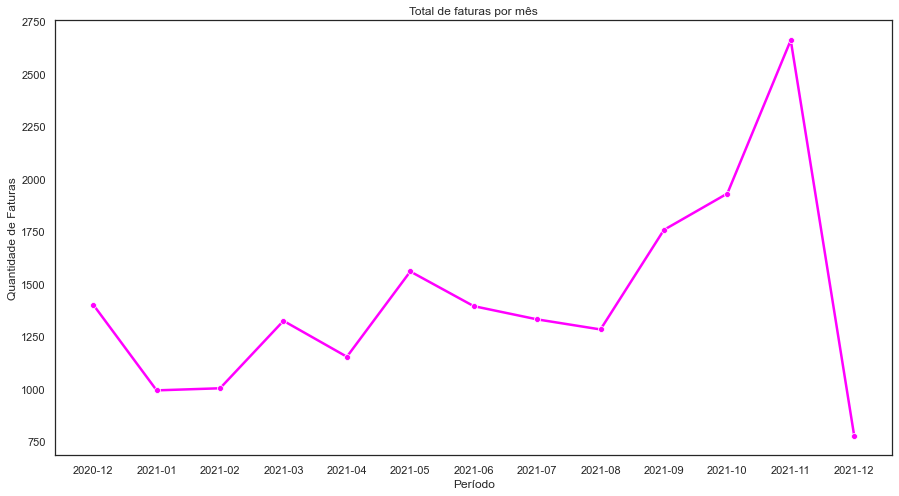

In [61]:
# plotando o gráfico
sns.set_theme(style="white", palette=None)
plt.figure(figsize = (15,8))
qtd_fatura = sns.lineplot(data=df_fatura_mes, x="Ano_mes", y="Quantidade_de_faturas", 
                            color="magenta",   linewidth=2.5, marker="o")
qtd_fatura.set_xlabel('Período')
qtd_fatura.set_ylabel('Quantidade de Faturas')
qtd_fatura.set_title('Total de faturas por mês')

## 3.4 Número de faturas do Reino Unido _versus_ estrangeiras por mês

Após segmentar os clientes da UK Merch em dois grupos: os que pertencem ao Reino Unido e os que não pertencem ao Reino Unido, agora iremos verificar a quantidade desses dois grupos.



Primeiramente iremos verificar quais são países que existem no nosso dataset.

In [63]:
df['País'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [64]:
# contando quantidade de faturas sem país especificado
nao_especificado = df[df['País']=='Unspecified']
nao_especificado.shape

(8, 8)

In [65]:
nao_especificado['Valor'].mean()

333.38375

In [66]:
nao_especificado['Valor'].sum()

2667.07

Percebe-se que existem 8 faturas que não possuem o país de origem definidos e não conseguidos garantir que estas faturas sejam ou não do Reino Unido. Porém como a soma e a média dos valores das faturas não apresentam tando impacto aos resultados finais quando comparados aos valores totais das faturas do dataset, então iremos realizar a análise contabilizando-os, deixando como não pertencentes ao Reino Unido nas somas gerais.

In [ ]:
# Criando coluna para classificar se o cliente pertence ou não ao Reino Unido
df.loc[df['País']=="United Kingdom", 'Pertence_UK'] = "SIM"
df.loc[df['País']!="United Kingdom", 'Pertence_UK'] = "NÃO"

In [67]:
# agrupando a quantidade de faturas por ano e se pertence ou não ao Reino Unido
df_fatura_mes_pais = pd.DataFrame(df.groupby(['Ano_mes', 'Pertence_UK'])['N°_da_fatura'].count()).reset_index()

# renomeando a coluna N°_da_fatura
df_fatura_mes_pais.rename(columns={"N°_da_fatura":"Quantidade_de_faturas"}, inplace=True)

# convertendo tipo do dado da coluna "Ano_mes" para string para ser utilizando no gráfico que será gerado
df_fatura_mes_pais['Ano_mes'] = df_fatura_mes_pais['Ano_mes'].astype(str)


Visualizando os dados em um gráfico de linhas

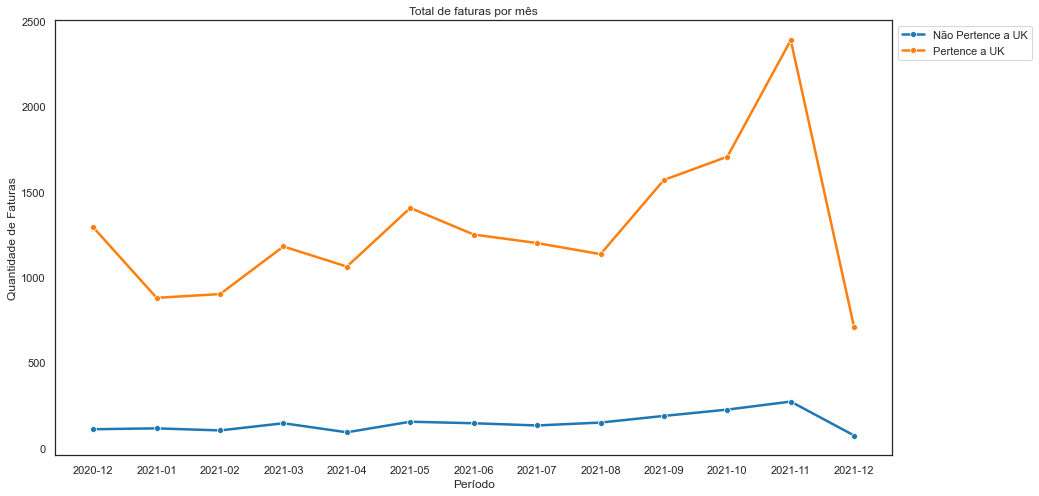

In [68]:
# plotando o gráfico
sns.set_theme(style="white", palette=None)
plt.figure(figsize = (15,8))
qtd_fatura = sns.lineplot(data=df_fatura_mes_pais, x="Ano_mes", y="Quantidade_de_faturas", 
                            hue="Pertence_UK", legend=False, palette="tab10", linewidth=2.5, marker="o")
qtd_fatura.set_xlabel('Período')
qtd_fatura.set_ylabel('Quantidade de Faturas')
qtd_fatura.set_title('Total de faturas por mês')

# alterando posição e nome dos dados da legenda
plt.legend(labels = ['Não Pertence a UK','Pertence a UK'],loc = 2, bbox_to_anchor = (1,1))

Analisando o gráfico pode-se perceber que, sem levar em conta o mês atípico de dezembro de 2021, ambos os segmentos estão crescendo.

## 3.5 Número de novos clientes por mês

Agora iremos analisar a quantidade de clientes únicos a cada mês


In [69]:
# Quantidade de clientes únicos por mês e ano
df_clientes_novos = pd.DataFrame(df.groupby(['Ano_mes'])['ID_Cliente'].nunique()).reset_index()
df_clientes_novos.columns = ['Ano_mes', 'Quantidade_clientes_unicos']
df_clientes_novos

,Ano_mes,Quantidade_clientes_unicos
0,2020-12,885
1,2021-01,741
2,2021-02,758
3,2021-03,974
4,2021-04,856
5,2021-05,1056
6,2021-06,991
7,2021-07,949
8,2021-08,935
9,2021-09,1266


In [70]:
# convertendo tipo do dado da coluna "Ano_mes" para string para ser utilizando no gráfico que será gerado
df_clientes_novos['Ano_mes'] = df_clientes_novos['Ano_mes'].astype(str)

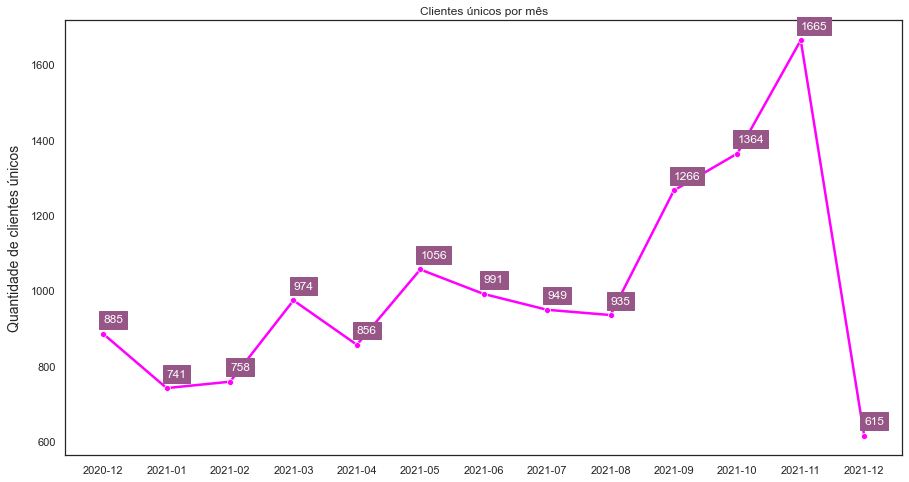

In [71]:
# definind

sns.set_theme(style="white", palette=None)
plt.figure(figsize = (15,8))


ax = sns.lineplot(data=df_clientes_novos, x="Ano_mes", y="Quantidade_clientes_unicos", 
                            color="magenta",   linewidth=2.5, marker="o")


ax.set_xlabel('', fontsize=14, labelpad=10)
ax.set_ylabel('Quantidade de clientes únicos', fontsize=14, labelpad=10)
ax.set_title('Clientes únicos por mês')


# incluindo rótulos nos pontos do gráfico
for x, y in zip(df_clientes_novos['Ano_mes'], df_clientes_novos['Quantidade_clientes_unicos']):
     plt.text(x = x, # posição x
               y = y+30, # posição y + 30 na coordenada
               s = '{:.0f}'.format(y), # formato 
               color = 'white').set_backgroundcolor('#965786') # cor da fonte e do background



## 3.6 Outras análises relevantes para o dataset

Quais outras análises interessantes podemos fazer?

- Montante total de vendas por mês

In [72]:
# realizando o cálculo total de vendas por mês
df_montante_mes = pd.DataFrame(df.groupby(['Ano_mes'])['Valor'].sum()).reset_index()
df_montante_mes.columns = ['Ano_mes', 'Montante Total de Vendas']

# transformando o valor em múltiplo de 1.000 ou K.
df_montante_mes['Montante Total de Vendas (K)'] = (df_montante_mes['Montante Total de Vendas']/1000).round(2)

# convertendo tipo do dado da coluna "Ano_mes" para string para ser utilizando no gráfico que será gerado
df_montante_mes['Ano_mes'] = df_montante_mes['Ano_mes'].astype(str)
    

Text(0, 0.5, 'Valor em Libras (k)')

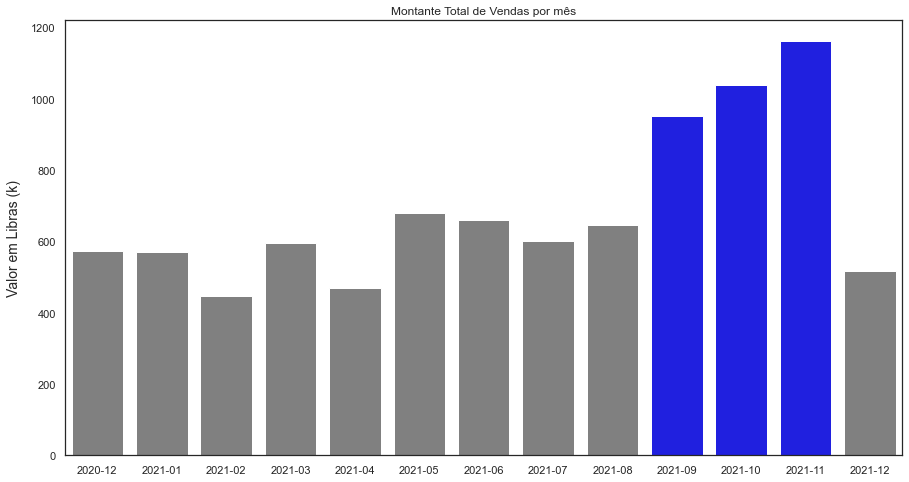

In [73]:
# selecionando o valor mínimo dos 3 maiores Montantes totais de vendas
minimo = min(df_montante_mes['Montante Total de Vendas (K)'].nlargest(n=3))

# colorindo de azul os 3 maiores e colorindo de cinza o restante
clrs = ['grey' if (x < minimo) else 'blue' for x in df_montante_mes['Montante Total de Vendas (K)']]

# criando o gráfico de barras
sns.set_theme(style="white", palette=None)
plt.figure(figsize = (15,8))
ax = sns.barplot(x="Ano_mes", y="Montante Total de Vendas (K)", data=df_montante_mes, ci=False, palette=clrs)

ax.set_title('Montante Total de Vendas por mês')
ax.set_xlabel('', fontsize=14, labelpad=10)
ax.set_ylabel('Valor em Libras (k)', fontsize=14, labelpad=10)

Podemos observar que os meses de _Setembro_, _Outubro_ e _Novembro de 2021_ tiveram o maior montante total, com os valores £952.84K, £1039.32K e £1161.82K, respectivamente.

- Montante de vendas dentro e fora do Reino Unido, por mês

Text(0, 0.5, 'Valor em Libras (k)')

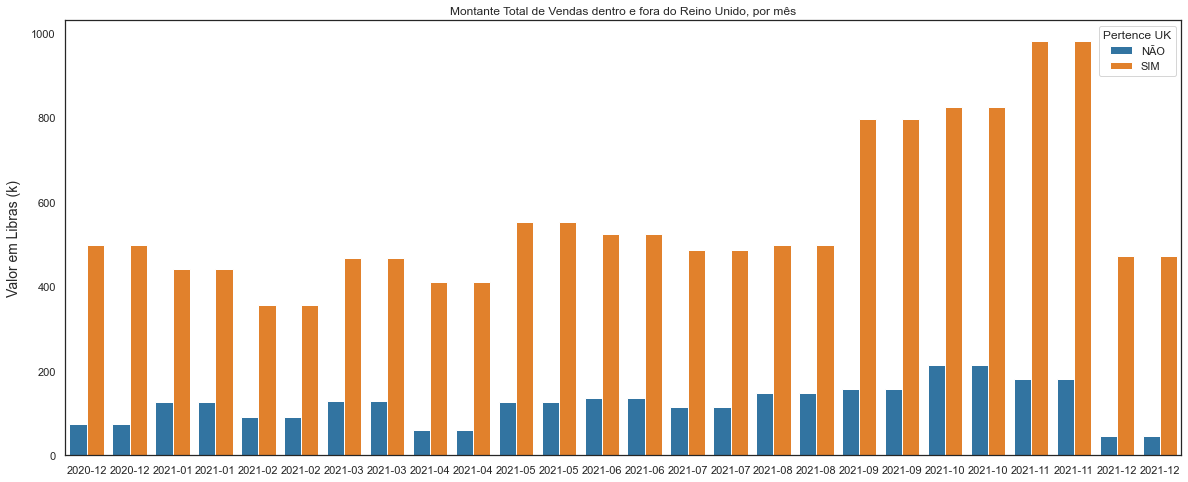

In [74]:
df_mes= pd.DataFrame(df.groupby(by=['Ano_mes','Pertence_UK'])['Valor'].sum()).reset_index()
df_mes.columns = ['Ano_mes','Pertence UK', 'Montante Total de Vendas']

# transformando o valor em múltiplo de 1.000 ou K.
df_mes['Montante Total de Vendas (K)'] = (df_mes['Montante Total de Vendas']/1000).round(2)

# convertendo tipo do dado da coluna "Ano_mes" para string para ser utilizando no gráfico que será gerado
df_mes['Ano_mes'] = df_mes['Ano_mes'].astype(str)


sns.set_theme(style="white", palette=None)
plt.figure(figsize = (20,8))
ax = sns.barplot(x="Ano_mes", y="Montante Total de Vendas (K)", data=df_mes, order=df_mes['Ano_mes'], hue='Pertence UK', ci=False)

ax.set_title('Montante Total de Vendas dentro e fora do Reino Unido, por mês')
ax.set_xlabel('', fontsize=14, labelpad=10)
ax.set_ylabel('Valor em Libras (k)', fontsize=14, labelpad=10)

Observando o gráfico de barras é possível perceber que a grande diferença nos valores de montantes das vendas para o Reino Unido que são bem maiores do que as vendas para fora do Reino Unido.

- 10 Maiores clientes que fizeram mais compras dentro e fora do Reino Unido, dentro de um mesmo mês

In [75]:
df_cliente_mes= pd.DataFrame(df.groupby(by=['ID_Cliente', 'Pertence_UK'])['Valor'].sum()).reset_index()
df_cliente_mes.columns = ['Cliente', 'Pertence_UK', 'Montante Total de Vendas']
df_cliente_mes.sort_values('Montante Total de Vendas', ascending=False, inplace=True)
df_cliente_mes = df_cliente_mes.head(10)

Text(0, 0.5, 'Valor em Libras')

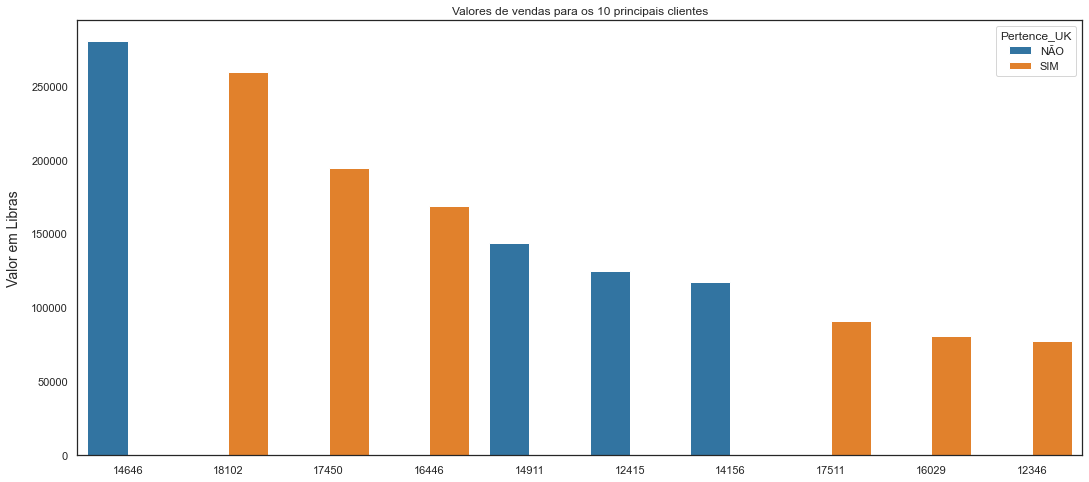

In [76]:
# criando o gráfico de barras
sns.set_theme(style="white", palette=None)
plt.figure(figsize = (18,8))
ax = sns.barplot(x="Cliente", y="Montante Total de Vendas", data=df_cliente_mes, hue='Pertence_UK', order=df_cliente_mes['Cliente'], ci=False)#, palette=clrs)
ax.set_title('Valores de vendas para os 10 principais clientes')
ax.set_xlabel('', fontsize=14, labelpad=10)
ax.set_ylabel('Valor em Libras', fontsize=14, labelpad=10)

- Quantidade mensal de produtos vendidos

In [77]:
df_produtos = pd.DataFrame(df.groupby(['Ano_mes'])['Quantidade'].sum()).reset_index()
df_produtos.columns = ['Ano_mes', 'Quantidade de Produtos Vendidos']
# convertendo tipo do dado da coluna "Ano_mes" para string para ser utilizando no gráfico que será gerado
df_produtos['Ano_mes'] = df_produtos['Ano_mes'].astype(str)

Text(0, 0.5, 'Quantidade')

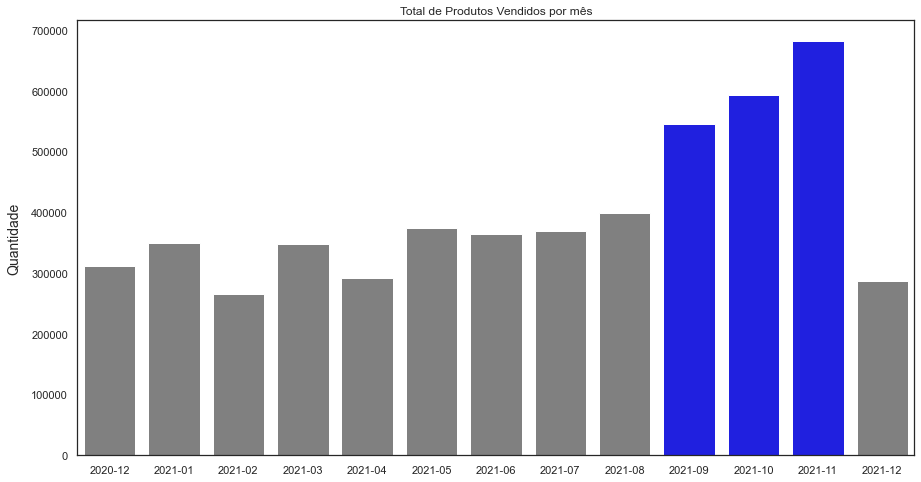

In [78]:
# selecionando o valor mínimo dos 3 maiores Montantes totais de vendas
minimo = min(df_produtos['Quantidade de Produtos Vendidos'].nlargest(n=3))

# colorindo de azul os 3 maiores e colorindo de cinza o restante
clrs = ['grey' if (x < minimo) else 'blue' for x in df_produtos['Quantidade de Produtos Vendidos']]

# criando o gráfico de barras
sns.set_theme(style="white", palette=None)
plt.figure(figsize = (15,8))
ax = sns.barplot(x="Ano_mes", y="Quantidade de Produtos Vendidos", data=df_produtos, ci=False, palette=clrs)

ax.set_title('Total de Produtos Vendidos por mês')
ax.set_xlabel('', fontsize=14, labelpad=10)
ax.set_ylabel('Quantidade', fontsize=14, labelpad=10)

- Ticket Médio

In [79]:
ticket = (df['Valor'].sum() / df['ID_Cliente'].count()).round(2)
ticket

479.99

O Ticket Médio é de **£479.99**.

- Ticket Médio Mensal

In [80]:
# Calculando o valor das vendas mensal
ticket = pd.DataFrame(df.groupby(by=['Ano_mes'])['Valor'].sum()).reset_index()

# Calculando a quantidade de clientes mensais
ticket2 = pd.DataFrame(df.groupby(by=['Ano_mes'])['ID_Cliente'].count()).reset_index()

# Unindo os dois dataframes criados 
ticket_mensal =  pd.merge(ticket, ticket2, on="Ano_mes")

# Calculando o valor do ticket médio mensal
for i in range(12):
    ticket_mensal['Ticket Médio Mensal'] = (ticket['Valor'] / ticket2['ID_Cliente']).round(2)

# convertendo tipo do dado da coluna "Ano_mes" para string para ser utilizando no gráfico que será gerado
ticket_mensal['Ano_mes'] = ticket_mensal['Ano_mes'].astype(str)

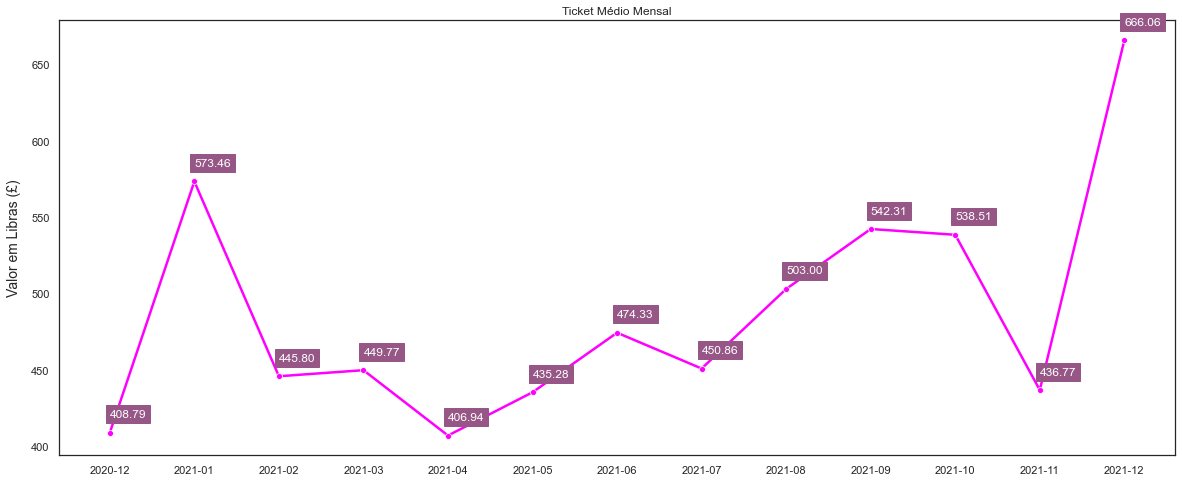

In [81]:
sns.set_theme(style="white", palette=None)
plt.figure(figsize = (20,8))


ax = sns.lineplot(data=ticket_mensal, x="Ano_mes", y="Ticket Médio Mensal", 
                            color="magenta",   linewidth=2.5, marker="o")


ax.set_xlabel('', fontsize=14, labelpad=10)
ax.set_ylabel('Valor em Libras (£)', fontsize=14, labelpad=10)
ax.set_title('Ticket Médio Mensal')


# incluindo rótulos nos pontos do gráfico
for x, y in zip(ticket_mensal['Ano_mes'], ticket_mensal['Ticket Médio Mensal']):
     plt.text(x = x, # posição x
               y = y+10, # posição y + 30 na coordenada
               s = '{:.2f}'.format(y), # formato 
               color = 'white').set_backgroundcolor('#965786') # cor da fonte e do background

# 4. Análise de Coorte

Salvando o arquivo `dados-coorte.csv` para ser utilizado na Análise de Coorte apresentada no Notebook 02 - Análise de coorte de clientes.

In [82]:

diretorio = "./dados/dados-tratados.csv"
df.to_csv(diretorio, sep=';', index=False)

# 5 - Segmentação de clientes

Será utilizado o arquivo `dados-coorte.csv` já salvado no diretório `dados` para ser utilizado no Notebook 03 - Segmentação de clientes usando RFM.


# Salvando os dados tratados para criação de análises no Google Data Studio

Essa seção foi criada para tratar os dados e facilitar o seu uso em planilhas Google Sheets e no Google Data Studio.

In [83]:
#alterando o tipo para string nas colunas que representam moeda nos dataframes para facilitar a manipulação no Google Sheets
df['Valor'] = df['Valor'].astype(str)

# alterando a separação dos valores de '.' para ',' na coluna Valor para facilitar conversão em moeda no Google Sheets
df['Valor'] = df['Valor'].str.replace(".", ",")

In [84]:
#alterando o tipo para string nas colunas que representam moeda nos dataframes para facilitar a manipulação no Google Sheets
df_analise_pais['Valor_médio'] = (df_analise_pais['Valor_médio']).astype(str)
df_analise_pais['Valor_mínimo'] = (df_analise_pais['Valor_mínimo']).astype(str)
df_analise_pais['Valor_máximo'] = (df_analise_pais['Valor_máximo']).astype(str)

# alterando a separação dos valores de '.' para ',' na coluna Valor para facilitar conversão em moeda no Google Sheets
df_analise_pais['Valor_médio'] = df_analise_pais['Valor_médio'].str.replace(".", ",")
df_analise_pais['Valor_mínimo'] = df_analise_pais['Valor_mínimo'].str.replace(".", ",")
df_analise_pais['Valor_máximo'] = df_analise_pais['Valor_máximo'].str.replace(".", ",")

In [85]:
# Salvando arquivo csv dos dados tratados 
diretorio = "./dados/dados-tratados-data-studio.csv"
df.to_csv(diretorio, sep=';', index=False, encoding='ISO-8859-1')

In [86]:
# Salvando arquivo csv das métricas geradas no item 3.2
diretorio = "./dados/analise-vendas-pais.csv"
df_analise_pais.to_csv(diretorio, sep=';', index=False, encoding='ISO-8859-1')